# Medical Image classification
Author: Jishnu Prakash Kunnanath Poduvattil & Akhil Raj

This notebook contains multi-class image classification using transfer learning. 

Methodology:-

Two Pretrained models, Resnet-18 and VGG-16 Nets are used for classification at first without training. Then a custom model is built by adding additional layers to Resnet-18 model and trained for improving the performance.

Pytorch is used to build deep neural networks for solving the classification problem. Scikit-learn metrics are used for evaluating the performance of the model. Matplotlib and seaborn are used for plotting the graphs.

## Imports and configurations

In [1]:
#Importing Libraries
import time
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets, models
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#Setting seed
np.random.seed(0)
torch.manual_seed(0)
%matplotlib inline
sns.set_style('darkgrid')

#Check for GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

We're using => cuda


## Data Preparation

In [3]:
#Defining image transformations for train and test
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256), #Resize image to (256,256)
        transforms.RandomResizedCrop(224), #Random crops of image to size (224, 224)
        transforms.RandomHorizontalFlip(p=0.5), #Do horizontal flip with probability of 50% 
        transforms.ToTensor(), #Convert to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Normalise values 
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(256), #Resize image to (256,256)
        transforms.CenterCrop(224), #Centre crop image to size (224, 224)
        transforms.ToTensor(), #Convert to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Normalise values 
    ])
}

In [4]:
#Define image dataloader
root_dir = 'Data/'
train = datasets.ImageFolder(root = root_dir + "train", transform = image_transforms["train"])
idx2class = {v: k for k, v in train.class_to_idx.items()}

print(train)
print(idx2class)

Dataset ImageFolder
    Number of datapoints: 5144
    Root location: Data/train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
{0: 'COVID19', 1: 'NORMAL', 2: 'PNEUMONIA'}


In [5]:
#Define functions to plot classes
def get_class_distribution(dataset_obj):
    """
    Get distribution of images in all classes
    """
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict

def plot_from_dict(dict_obj, plot_title, **kwargs):
    """
    Generate bar plot from dictionary
    """
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)

def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    """
    Get distribution of images from dataloaders
    """
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    if dataloader_obj.batch_size == 1:    
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class[y_idx]
            count_dict[str(y_lbl)] += 1
    else: 
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class[y_idx]
                count_dict[str(y_lbl)] += 1
    return count_dict

Text(0.5, 1.0, 'Entire Dataset (before train/val/test split)')

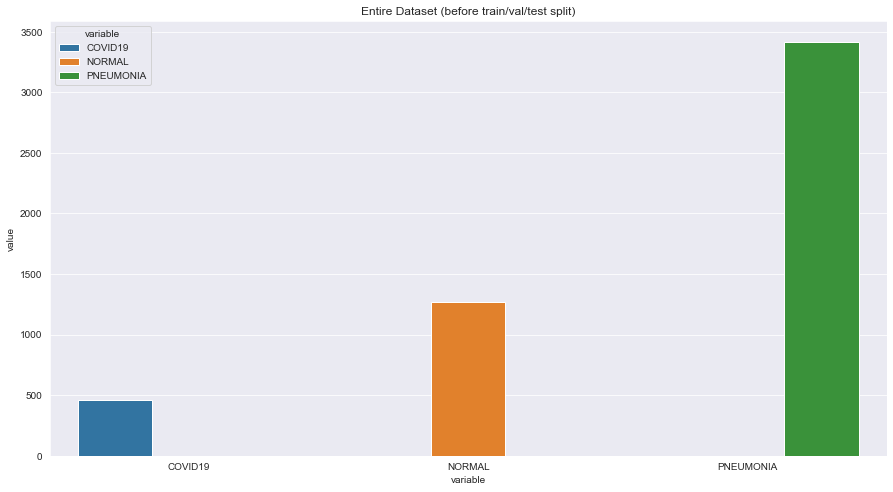

In [11]:
#Plot Overall distribution of images
plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(train), plot_title="Entire Dataset (before train/val/test split)")

From the above plot, we can see that the image data is imbalanced. Let us prepare trian and validation data and then resolve the imbalance issues. 

In [6]:
#Define validation data split
train_indices = list(range(len(train)))
np.random.shuffle(train_indices)

val_split = 0.2
val_split_index = int(np.floor(val_split * len(train)))
train_idx, val_idx = train_indices[val_split_index:], train_indices[:val_split_index]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [7]:
#Define test image loader
test = datasets.ImageFolder(root = root_dir + "test", transform = image_transforms["test"])
test

Dataset ImageFolder
    Number of datapoints: 1288
    Root location: Data/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [8]:
# Load images
train_loader = DataLoader(dataset=train, shuffle=False, batch_size=16, sampler=train_sampler, num_workers=8) #Change num_workers according to your CPU/GPU configuration
val_loader = DataLoader(dataset=train, shuffle=False, batch_size=16, sampler=val_sampler, num_workers=8)
test_loader = DataLoader(dataset=test, shuffle=True, batch_size=1)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_idx), 'val': len(val_idx), 'test': len(test)}
class_names = train.classes

Text(0.5, 1.0, 'Val Set')

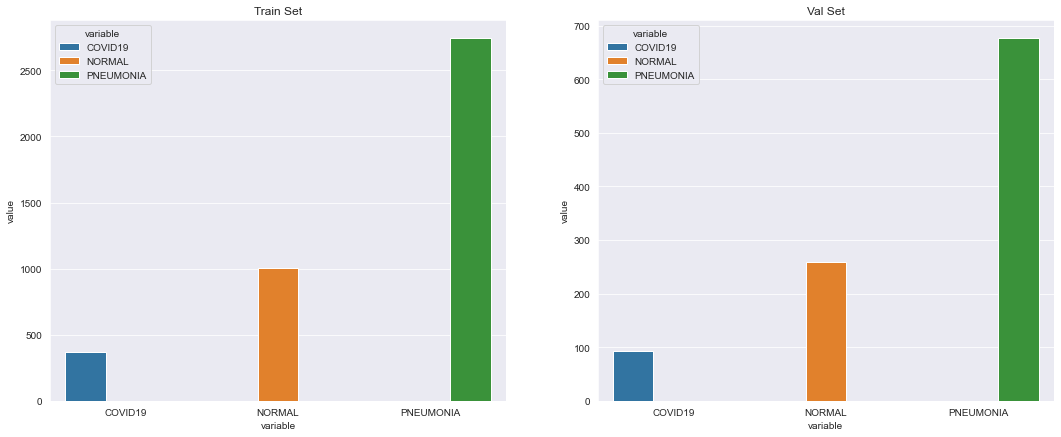

In [9]:
#Plot train, val, test data distribution
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
train_classes = get_class_distribution_loaders(train_loader, train)
val_classes = get_class_distribution_loaders(val_loader, train)

plot_from_dict(train_classes, plot_title="Train Set", ax=axes[0])
plot_from_dict(val_classes, plot_title="Val Set", ax=axes[1])

To train the models with imbalanced data, class weights can be initialized according to data size.

In [10]:
# Define Class weights
weight = torch.FloatTensor([train_classes['COVID19'] / dataset_sizes['train'],
                            train_classes['NORMAL'] / dataset_sizes['train'],
                            train_classes['PNEUMONIA'] / dataset_sizes['train']]).to(device)
print(weight)

tensor([0.0892, 0.2447, 0.6662], device='cuda:0')


The above weights can be initialised with loss function and thus we can resolve the bias.

In [9]:
#Load single batch
single_batch = next(iter(train_loader))
single_batch[0].shape
print("Output label tensors: ", single_batch[1])
print("\nOutput label tensor shape: ", single_batch[1].shape)


Output label tensors:  tensor([1, 2, 2, 0, 1, 1, 2, 0, 1, 2, 2, 0, 2, 2, 1, 2])

Output label tensor shape:  torch.Size([16])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


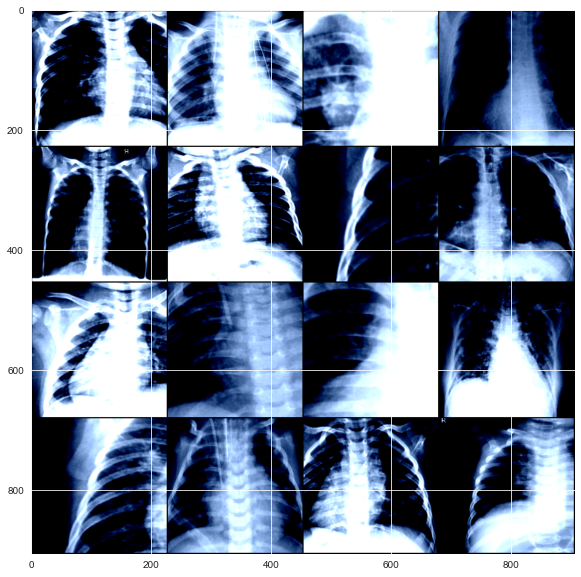

In [10]:
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))

## Define Functions to train, predict and evaluate

In [11]:
def train_model(model, criterion, optimizer, num_epochs=25, schedule=False):
    """
    Train model with given hyperparameters
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Decay LR by a factor of 0.1 every 7 epochs
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[] } #Evaluation metrics

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train' and schedule == True:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase=='train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

def predict(model, dataloaders, map=idx2class):
    model.eval()
    y_pred= []
    y_true = []
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            pred = model(inputs)
            # print(pred)
            _, y_pred_tag = torch.max(pred, dim = 1)
            y_pred.append(y_pred_tag.cpu().numpy())
            y_true.append(labels.cpu().numpy())
    y_pred = [map[i[0]] for i in y_pred]
    y_true = [map[i[0]] for i in y_true]
    return y_true, y_pred

def plotPerformance(history, epochs): 
    #Accuracy
    plt.plot(range(0, epochs), history['train_acc'], color='red', label='Train accuracy')
    plt.plot(range(0, epochs), history['val_acc'], color='blue', label='Validation accuracy')
    plt.legend()
    plt.show()

    #Loss
    plt.plot(range(0, epochs), history['train_loss'], color='red', label='Train Loss')
    plt.plot(range(0, epochs), history['val_loss'], color='blue', label='Validation Loss')
    plt.legend()
    plt.show()

# Part 1
## Prediction using VGG-16

Here, we are using VGG-16 model with weights trained on ImageNet dataset of 1000 classes. We are going to change the final layer and predict our test data to observe how the weights performs on our data. No training is done as suggested in the assignment specification.

Steps:-

 - Load VGG-16 pretrained model
 - Change final layer (From 1000 classes to 3 classes)
 - Predict using test data
 - Compute model performance

In [20]:
#Load pretrained model
vgg16 = models.vgg16(pretrained=True).to(device)
#Change final layer
vgg16.classifier[6] = nn.Linear(4096, 3).to(device)

In [20]:
y_true, y_pred = predict(vgg16, dataloaders) #predict
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

     COVID19       0.09      0.69      0.17       116
      NORMAL       0.45      0.63      0.53       317
   PNEUMONIA       0.00      0.00      0.00       855

    accuracy                           0.22      1288
   macro avg       0.18      0.44      0.23      1288
weighted avg       0.12      0.22      0.15      1288

[[ 80  36   0]
 [115 201   1]
 [650 205   0]]


We can see that VGG-16 gives poor performance. This behaviour is expected since we are not training the model.

## 1.2 Prediction using Resnet-18

Here, we are using Resnet-18 model with weights trained on ImageNet dataset of 1000 classes. We are going to change the final layer and predict our test data to observe how the weights performs on our data. No training is done as suggested in the assignment specification.

Steps:-

 - Load Resnet-18 pretrained model
 - Change final layer (From 1000 classes to 3 classes)
 - Predict using test data
 - Compute model performance

In [15]:
#Load pretrained model
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
#Change final layer
resnet18.fc = nn.Linear(512,3).to(device)


In [16]:
y_true, y_pred = predict(resnet18, dataloaders)
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

     COVID19       0.10      0.27      0.15       116
      NORMAL       0.28      0.35      0.31       317
   PNEUMONIA       0.70      0.48      0.57       855

    accuracy                           0.43      1288
   macro avg       0.36      0.37      0.34      1288
weighted avg       0.55      0.43      0.47      1288

[[ 31  40  45]
 [ 76 111 130]
 [201 241 413]]


We can see a slightly better performance of Resnet-18 than VGG-16.

# Part 2
Now, we are going to finetune the Resnet-18 model for transfer learning.

1) We are going to train the final layer by freezing all other layers.

2) We are going to add some layers before average pooling and in the fully connected/classification part of the model
## 2.1 Training the fully-connected layer only

In [10]:
#Load model
resnet18b = models.resnet18(pretrained=True).to(device)
#Change final layer
resnet18b.fc = nn.Linear(512, 3).to(device)

#Freeze all layers
for param in resnet18b.parameters():
    param.requires_grad = False

#UnFreeze fully connected layers
for param in resnet18b.fc.parameters():
    param.requires_grad = True

#Use defined class weights here
criterion = nn.CrossEntropyLoss(weight=weight).to(device)

#Define optimizer
optimizer = optim.SGD(resnet18b.fc.parameters(), lr=0.001, momentum=0.9)

In [11]:
#Training
epochs = 25
train_resnet18b = train_model(resnet18b, criterion, optimizer, num_epochs=epochs)

Epoch 0/24
----------
train Loss: 0.3466 Acc: 0.7242
val Loss: 0.3089 Acc: 0.7977
Epoch 1/24
----------
train Loss: 0.2740 Acc: 0.7677
val Loss: 0.2504 Acc: 0.8025
Epoch 2/24
----------
train Loss: 0.2576 Acc: 0.7828
val Loss: 0.2313 Acc: 0.7821
Epoch 3/24
----------
train Loss: 0.2402 Acc: 0.7877
val Loss: 0.2521 Acc: 0.8405
Epoch 4/24
----------
train Loss: 0.2418 Acc: 0.7962
val Loss: 0.2395 Acc: 0.8317
Epoch 5/24
----------
train Loss: 0.2285 Acc: 0.8015
val Loss: 0.2250 Acc: 0.8278
Epoch 6/24
----------
train Loss: 0.2246 Acc: 0.8124
val Loss: 0.2198 Acc: 0.8006
Epoch 7/24
----------
train Loss: 0.2370 Acc: 0.8037
val Loss: 0.2197 Acc: 0.8638
Epoch 8/24
----------
train Loss: 0.2191 Acc: 0.8190
val Loss: 0.2193 Acc: 0.8084
Epoch 9/24
----------
train Loss: 0.2267 Acc: 0.8163
val Loss: 0.2061 Acc: 0.8512
Epoch 10/24
----------
train Loss: 0.2166 Acc: 0.8202
val Loss: 0.2165 Acc: 0.8230
Epoch 11/24
----------
train Loss: 0.2152 Acc: 0.8294
val Loss: 0.1907 Acc: 0.8570
Epoch 12/24
--

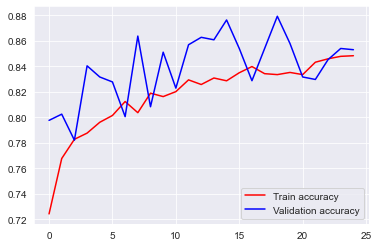

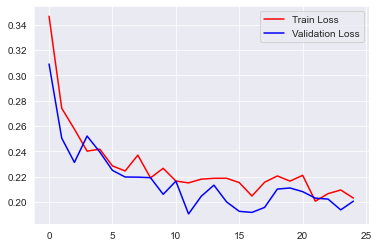

In [12]:
plotPerformance(train_resnet18b[1], epochs)

In [13]:
y_true, y_pred = predict(train_resnet18b[0], dataloaders)
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

     COVID19       0.97      0.75      0.84       116
      NORMAL       0.92      0.81      0.87       317
   PNEUMONIA       0.91      0.98      0.94       855

    accuracy                           0.92      1288
   macro avg       0.93      0.85      0.88      1288
weighted avg       0.92      0.92      0.91      1288

[[ 87   0  29]
 [  3 258  56]
 [  0  21 834]]


We can observe a good performance here. This explains the power of transfer learning.

## 2.1 Adding additional Layers

 - Adding a dropout and convolution-batch normalisation-relu (C-B-R) combination before average pooling
 - Adding 2 layers as fully connected layers

In [16]:
#load model
custom2 = torchvision.models.resnet18(pretrained=True).to(device)

#Define Custom layer
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()
        self.drop1 = nn.Dropout(p=0.5)
        self.conv1 = nn.Conv2d(512, 512, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn1 = nn.BatchNorm2d(512)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.drop1(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.avgpool(x)
        return x

#Define fully connected layers
class FullyConnected(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1=nn.Linear(512,256)
        self.linear2=nn.Linear(256,3)
    
    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return x

custom2.avgpool = CustomLayer().to(device)
custom2.fc = FullyConnected().to(device)
print(custom2)
#Use defined class weights here
criterion = nn.CrossEntropyLoss(weight=weight).to(device)
#Define optimizer
optimizer = optim.SGD(custom2.parameters(), lr=0.001, momentum=0.9)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
#Training
epochs = 15
train_custom2 = train_model(custom2, criterion, optimizer, num_epochs=epochs)

Epoch 0/14
----------
train Loss: 0.4401 Acc: 0.6640
val Loss: 0.3465 Acc: 0.7062
Epoch 1/14
----------
train Loss: 0.2622 Acc: 0.7818
val Loss: 0.3437 Acc: 0.8220
Epoch 2/14
----------
train Loss: 0.2108 Acc: 0.8314
val Loss: 0.2441 Acc: 0.8298
Epoch 3/14
----------
train Loss: 0.1939 Acc: 0.8406
val Loss: 0.1909 Acc: 0.8473
Epoch 4/14
----------
train Loss: 0.1761 Acc: 0.8462
val Loss: 0.2088 Acc: 0.8453
Epoch 5/14
----------
train Loss: 0.1712 Acc: 0.8416
val Loss: 0.1910 Acc: 0.8512
Epoch 6/14
----------
train Loss: 0.1576 Acc: 0.8455
val Loss: 0.1786 Acc: 0.8531
Epoch 7/14
----------
train Loss: 0.1412 Acc: 0.8550
val Loss: 0.1522 Acc: 0.8609
Epoch 8/14
----------
train Loss: 0.1393 Acc: 0.8552
val Loss: 0.1546 Acc: 0.8774
Epoch 9/14
----------
train Loss: 0.1284 Acc: 0.8671
val Loss: 0.2038 Acc: 0.8755
Epoch 10/14
----------
train Loss: 0.1254 Acc: 0.8746
val Loss: 0.2318 Acc: 0.9018
Epoch 11/14
----------
train Loss: 0.1259 Acc: 0.8873
val Loss: 0.1490 Acc: 0.9300
Epoch 12/14
--

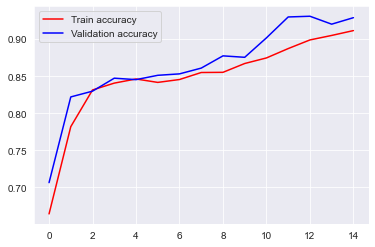

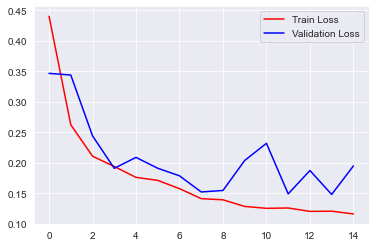

In [18]:
plotPerformance(train_custom2[1], epochs)

In [19]:
y_true, y_pred = predict(train_custom2[0], dataloaders)
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

     COVID19       1.00      0.91      0.95       116
      NORMAL       0.92      0.90      0.91       317
   PNEUMONIA       0.96      0.98      0.97       855

    accuracy                           0.95      1288
   macro avg       0.96      0.93      0.95      1288
weighted avg       0.95      0.95      0.95      1288

[[106   9   1]
 [  0 284  33]
 [  0  15 840]]


We can observe best performance when the weights are initialised from ImageNet. We got a validation accuracy of 93 % and test accuracy of 95%.
This shows the importance of transfer learning in the domain of medical imaging.